In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.1.0


#  Dataset Preprocessing

In [2]:
#df = pd.read_csv('../input/datatweets/dane.csv')
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', 
                 encoding='latin-1') #
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
#df.columns = ['ID','Text', 'Label']

df.columns = ['Label', 'id', 'date', 'query', 'user_id', 'Text'] #

df.head()

,Label,id,date,query,user_id,Text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
#df = df.drop(['ID'], axis=1)
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1) #
df.head()


,Label,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [5]:
#convert = {1:"Hate", 0:"NonHate"}
convert = {0:"Hate", 4:"NonHate"} #

def label_decoder(label):
  return convert[label]

df.Label = df.Label.apply(lambda x: label_decoder(x))
df.head()

,Label,Text
0,Hate,is upset that he can't update his Facebook by ...
1,Hate,@Kenichan I dived many times for the ball. Man...
2,Hate,my whole body feels itchy and like its on fire
3,Hate,"@nationwideclass no, it's not behaving at all...."
4,Hate,@Kwesidei not the whole crew


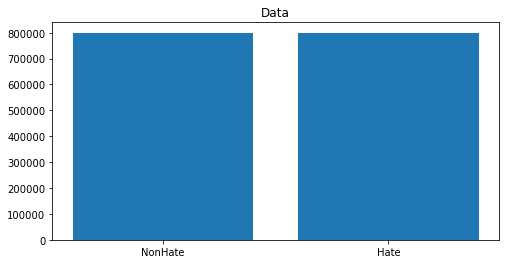

In [6]:
val_count = df.Label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data")

df_new = df #

In [7]:
# df_hate = df.loc[df["Label"]=="Hate",:]
# df_non_hate = df.loc[df["Label"]=="NonHate",:].head(1186)

# df_new = df_hate.append(df_non_hate)
# df_new = df_new.sample(frac=1)
# df_new

# Visual


#### Non Hate

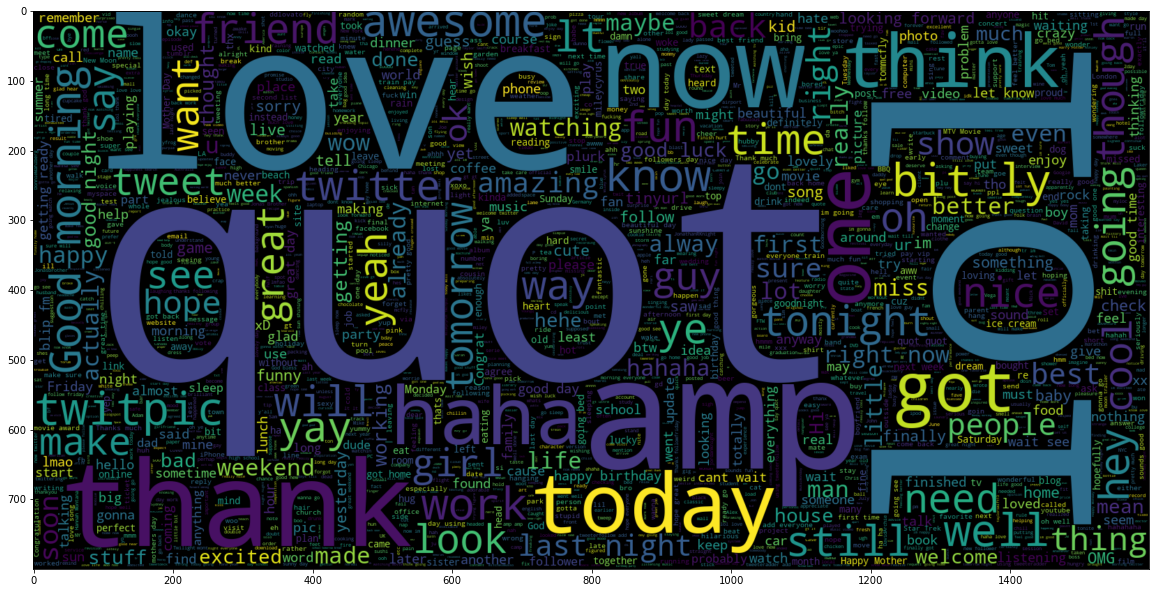

In [8]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_new[df_new.Label == 'NonHate'].Text))
plt.imshow(wc , interpolation = 'bilinear')

#### Hate

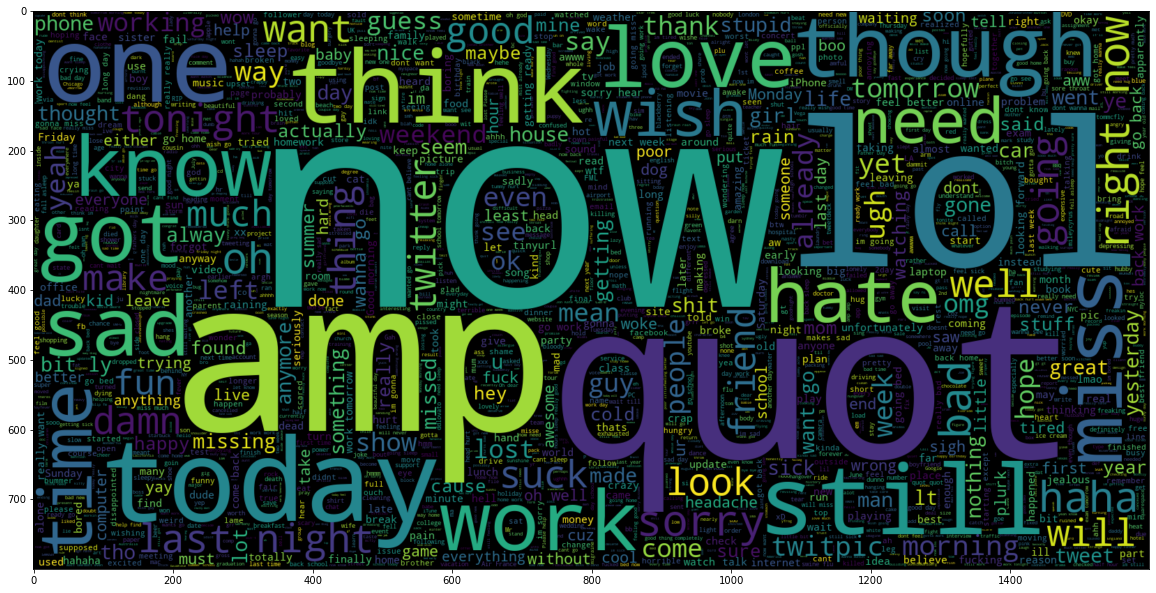

In [9]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_new[df_new.Label == 'Hate'].Text))
plt.imshow(wc , interpolation = 'bilinear')

In [10]:
df_new

,Label,Text
0,Hate,is upset that he can't update his Facebook by ...
1,Hate,@Kenichan I dived many times for the ball. Man...
2,Hate,my whole body feels itchy and like its on fire
3,Hate,"@nationwideclass no, it's not behaving at all...."
4,Hate,@Kwesidei not the whole crew
...,...,...
1599994,NonHate,Just woke up. Having no school is the best fee...
1599995,NonHate,TheWDB.com - Very cool to hear old Walt interv...
1599996,NonHate,Are you ready for your MoJo Makeover? Ask me f...
1599997,NonHate,Happy 38th Birthday to my boo of alll time!!! ...


# Train and Test Split

In [11]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [12]:
train_data, test_data = train_test_split(df_new, test_size=1-TRAIN_SIZE,random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1279999
Test Data size 320000


In [13]:
train_data.head(10)

,Label,Text
1176709,NonHate,@emlynley lol You will get what's coming to yo...
641121,Hate,@xXFriendXx I would miss dreaming if I didn't ...
1132400,NonHate,@CCavallari @poletii http://bit.ly/1psbO chec...
130866,Hate,im sick the only thing that would make me fee...
1235875,NonHate,@AnnieMcBeth Sounds like my cup of tea. Where ...
1568154,NonHate,I think I'm going to take a hot bath &amp; lis...
758235,Hate,"I feel tired today , i`m not going to Gym"
1446219,NonHate,weekend ...resting in peace ..finally
763239,Hate,I am sooo jealous....I hope one day I can make...
584093,Hate,@juanitaaaa don't say that i'll cry hahah


# Tokenization

In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.Text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Using TensorFlow backend.


Vocabulary Size : 594610


In [15]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1279999, 30)
Testing X Shape: (320000, 30)


In [16]:
labels = train_data.Label.unique().tolist()

### Label Encoding 

In [17]:
encoder = LabelEncoder()
encoder.fit(train_data.Label.to_list())

y_train = encoder.transform(train_data.Label.to_list())
y_test = encoder.transform(test_data.Label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1279999, 1)
y_test shape: (320000, 1)


# Word Emdedding


In [18]:
#GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
GLOVE_EMB = '../input/glove6b300dtxt/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
#EPOCHS = 8
EPOCHS = 12
#MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [19]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training - LSTM


### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)


1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors. 

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [22]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

# Optimization Algorithm

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [25]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Train on 1279999 samples, validate on 320000 samples
Epoch 1/12
1279999/1279999 [==============================] - 139s 108us/sample - loss: 0.4917 - accuracy: 0.7598 - val_loss: 0.4410 - val_accuracy: 0.7929
Epoch 2/12
1279999/1279999 [==============================] - 130s 101us/sample - loss: 0.4485 - accuracy: 0.7890 - val_loss: 0.4277 - val_accuracy: 0.8017
Epoch 3/12
1279999/1279999 [==============================] - 129s 101us/sample - loss: 0.4352 - accuracy: 0.7968 - val_loss: 0.4198 - val_accuracy: 0.8053
Epoch 4/12
1279999/1279999 [==============================] - 131s 102us/sample - loss: 0.4267 - accuracy: 0.8017 - val_loss: 0.4204 - val_accuracy: 0.8066
Epoch 5/12
1279999/1279999 [==============================] - 130s 101us/sample - loss: 0.4214 - accuracy: 0.8047 - val_loss: 0.4127 - val_accuracy: 0.8098
Epoch 6/12
1279999/1279999 [==============================] - 129s 101us/sample - loss: 0.4169 - accuracy: 0.8077 - val_loss: 0.4124 - val_accuracy: 0.8092
Epoch 7/12


# Model Evaluation

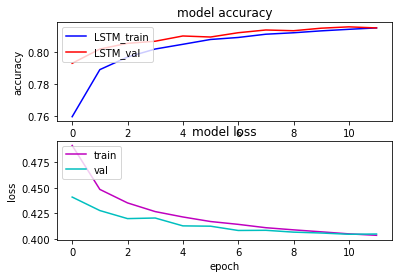

In [26]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

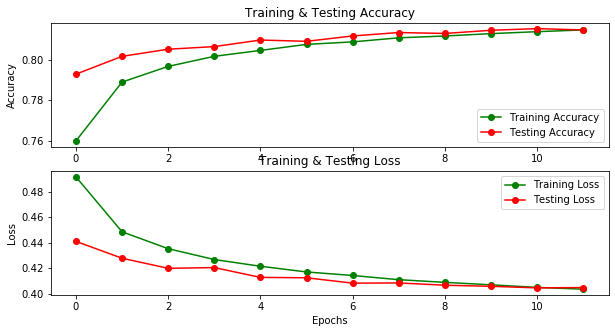

In [27]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(2,1)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
# ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [28]:
# def decode_sentiment(score):
#     return "NonHate" if score>0.5 else "Hate"


# scores = model.predict(x_test, verbose=1, batch_size=10000)
# y_pred_1d = [decode_sentiment(score) for score in scores]

### Confusion Matrix

In [29]:
# predict_x=model.predict(x_test) 
# classes_x=np.argmax(predict_x,axis=1)
# classes_x[:5]

array([0, 0, 0, 0, 0])

In [32]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)

Text(69.0, 0.5, 'Actual')

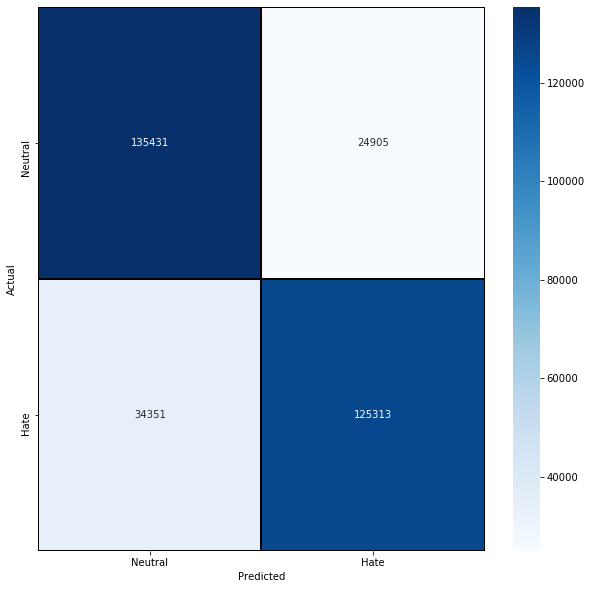

In [35]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Neutral','Hate'] , yticklabels = ['Neutral','Hate'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

### recall

In [36]:
from sklearn.metrics import recall_score
recall_score(y_test,y_pred)

0.7848544443330995

### f1 score

In [37]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)


0.8087788254884117